In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io

# Check for python-chess
try:
    import chess.pgn
    import chess
except ImportError:
    print("Error: 'python-chess' library is not installed. Install it using: pip install python-chess")
    exit()

# Set visualization style for clean plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Define file paths
input_path = r'D:\SHARDUL\STUDY\CHESS.COM EDA\archive (3)\club_games_data.csv'
output_path = r'D:\SHARDUL\STUDY\CHESS.COM EDA\preprocessed_club_games.csv'
output_dir = r'D:\SHARDUL\STUDY\CHESS.COM EDA'

# Create output directory if it doesn't exist
try:
    os.makedirs(output_dir, exist_ok=True)
except Exception as e:
    print(f"Error creating directory {output_dir}: {e}")
    exit()

# Load the dataset
try:
    df = pd.read_csv(input_path)
except FileNotFoundError:
    print(f"Error: File not found at {input_path}. Please verify.")
    exit()
except Exception as e:
    print(f"Error loading file: {e}")
    exit()


In [2]:
# Display dataset info
print("=== Dataset Overview ===")
print("Columns:", df.columns.tolist())
print("\nShape:", df.shape)
print("\nMissing Values:", df.isnull().sum())
print("\nData Types:\n", df.dtypes)
print("\nSample Data:\n", df.head())

=== Dataset Overview ===
Columns: ['white_username', 'black_username', 'white_id', 'black_id', 'white_rating', 'black_rating', 'white_result', 'black_result', 'time_class', 'time_control', 'rules', 'rated', 'fen', 'pgn']

Shape: (66879, 14)

Missing Values: white_username    0
black_username    0
white_id          0
black_id          0
white_rating      0
black_rating      0
white_result      0
black_result      0
time_class        0
time_control      0
rules             0
rated             0
fen               0
pgn               0
dtype: int64

Data Types:
 white_username    object
black_username    object
white_id          object
black_id          object
white_rating       int64
black_rating       int64
white_result      object
black_result      object
time_class        object
time_control      object
rules             object
rated               bool
fen               object
pgn               object
dtype: object

Sample Data:
   white_username black_username                         

In [3]:
# Remove duplicates
initial_rows = len(df)
df = df.drop_duplicates()
print(f"\nRemoved {initial_rows - df.shape[0]} duplicate rows.")


Removed 4 duplicate rows.


In [4]:
# Add derived columns
# Rating difference (White Rating - Black Rating)
df['rating_diff'] = df['white_rating'] - df['black_rating']
df['rating_diff_bin'] = pd.cut(df['rating_diff'], 
                               bins=[-float('inf'), -200, -50, 50, 200, float('inf')],
                               labels=['Black >> White', 'Black > White', 'Equal', 
                                       'White > Black', 'White >> Black'])
print("\nAdded derived columns: 'rating_diff', 'rating_diff_bin'")


Added derived columns: 'rating_diff', 'rating_diff_bin'


In [5]:
# Base time from time_control (e.g., '1/259200' -> days, '10+0' -> minutes)
df['base_time'] = df['time_control'].apply(
    lambda x: float(x.split('/')[1])/86400 if '/' in x else float(x.split('+')[0])
)
print("Added derived column: 'base_time' (time control in days or minutes)")

Added derived column: 'base_time' (time control in days or minutes)


In [6]:
# Extract move count and first move from PGN with debugging
def parse_pgn(pgn_str):
    if not isinstance(pgn_str, str) or not pgn_str.strip():
        return np.nan, np.nan
    try:
        pgn = io.StringIO(pgn_str)
        game = chess.pgn.read_game(pgn)
        if game is None:
            return np.nan, np.nan
        moves = list(game.mainline_moves())
        move_count = len(moves) // 2
        first_move = str(moves[0]) if moves else np.nan
        return move_count, first_move
    except Exception as e:
        print(f"PGN parsing error for string '{pgn_str[:50]}...': {e}")
        return np.nan, np.nan

In [7]:
# Apply PGN parsing and debug
print("\nParsing PGN data...")
pgn_results = df['pgn'].apply(parse_pgn)
successful_parses = pgn_results.apply(lambda x: not (pd.isna(x[0]) and pd.isna(x[1]))).sum()
print(f"Successfully parsed {successful_parses} out of {len(df)} PGN entries")


Parsing PGN data...
Successfully parsed 66875 out of 66875 PGN entries


In [8]:
# Create columns
try:
    df[['move_count', 'first_move']] = pgn_results.apply(pd.Series)
    print("Added derived columns: 'move_count', 'first_move'")
except Exception as e:
    print(f"Error creating move_count/first_move columns: {e}")
    df['move_count'] = np.nan
    df['first_move'] = np.nan

Added derived columns: 'move_count', 'first_move'


In [9]:
# Count pieces in final FEN position
def count_pieces(fen):
    if not isinstance(fen, str):
        return np.nan
    try:
        board = chess.Board(fen)
        return sum(1 for _ in board.piece_map())
    except Exception as e:
        print(f"FEN parsing error for string '{fen[:50]}...': {e}")
        return np.nan

df['piece_count'] = df['fen'].apply(count_pieces)
print("Added derived column: 'piece_count' (pieces in final position)")

Added derived column: 'piece_count' (pieces in final position)


In [10]:
# Save preprocessed data
try:
    df.to_csv(output_path, index=False)
    print(f"\nPreprocessed data saved to {output_path}")
except Exception as e:
    print(f"Error saving preprocessed data: {e}")


Preprocessed data saved to D:\SHARDUL\STUDY\CHESS.COM EDA\preprocessed_club_games.csv


In [11]:
# EDA: Visualizations and Statistics
print("\n=== Exploratory Data Analysis ===")


=== Exploratory Data Analysis ===


Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\white_result_distribution.png


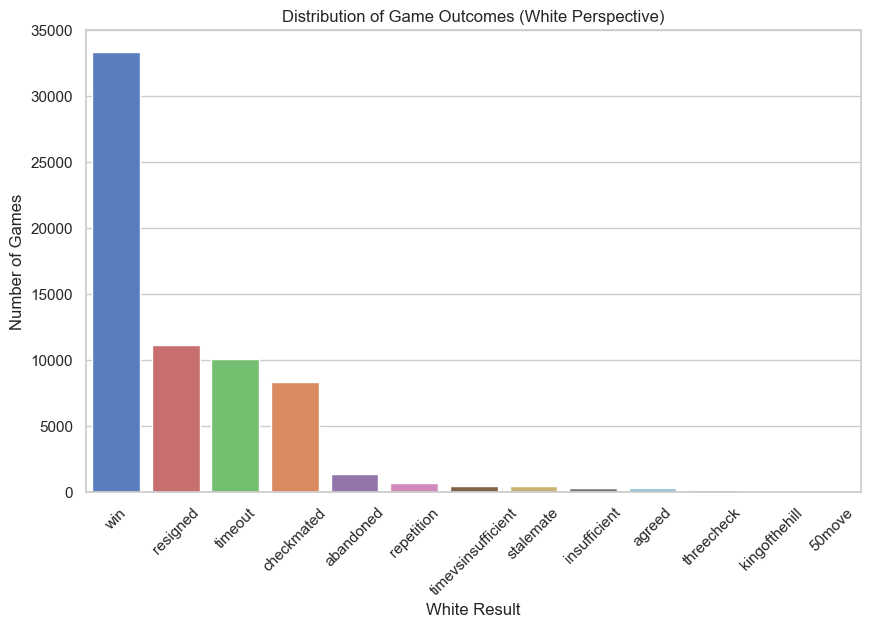


1. Game Outcome Counts (White Perspective):
 white_result
win                   33349
resigned              11170
timeout               10088
checkmated             8359
abandoned              1404
repetition              712
timevsinsufficient      469
stalemate               464
insufficient            336
agreed                  324
threecheck              121
kingofthehill            73
50move                    6
Name: count, dtype: int64

Outcome Proportions:
 white_result
win                   0.498677
resigned              0.167028
timeout               0.150849
checkmated            0.124994
abandoned             0.020994
repetition            0.010647
timevsinsufficient    0.007013
stalemate             0.006938
insufficient          0.005024
agreed                0.004845
threecheck            0.001809
kingofthehill         0.001092
50move                0.000090
Name: count, dtype: float64


In [12]:
# 1. Game Outcomes (White Perspective)
if df['white_result'].notna().any() and df['white_result'].nunique() > 0:
    plt.figure()
    sns.countplot(data=df, x='white_result', hue='white_result', 
                  order=df['white_result'].value_counts().index, 
                  palette='muted', legend=False)
    plt.title('Distribution of Game Outcomes (White Perspective)')
    plt.xlabel('White Result')
    plt.ylabel('Number of Games')
    plt.xticks(rotation=45)
    try:
        plt.savefig(os.path.join(output_dir, 'white_result_distribution.png'))
        print(f"Saved plot: {os.path.join(output_dir, 'white_result_distribution.png')}")
    except Exception as e:
        print(f"Error saving white_result_distribution.png: {e}")
    plt.show()
    plt.close()
    outcome_counts = df['white_result'].value_counts()
    print("\n1. Game Outcome Counts (White Perspective):\n", outcome_counts)
    print("\nOutcome Proportions:\n", outcome_counts / outcome_counts.sum())
else:
    print("\nWarning: 'white_result' is empty or invalid. Skipping game outcomes plot.")

Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\rating_distribution.png


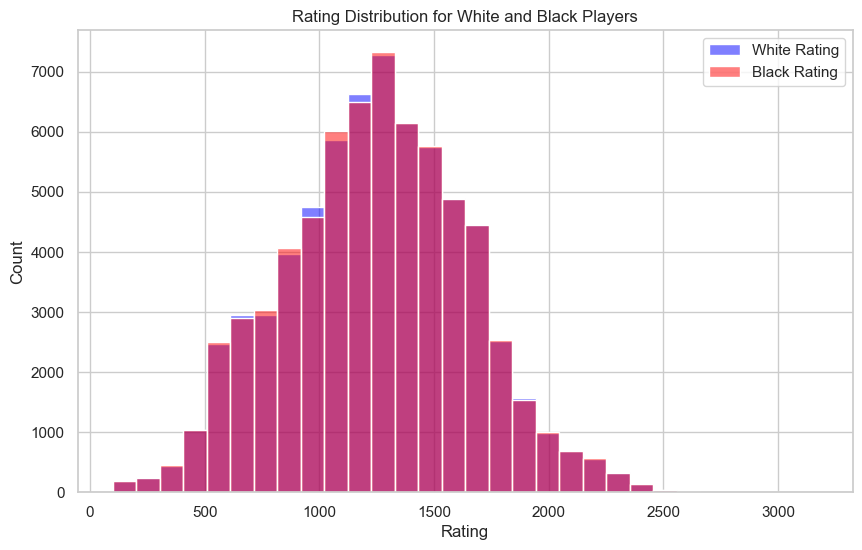


2. Rating Statistics:
        white_rating  black_rating
count  66875.000000  66875.000000
mean    1247.594258   1246.991536
std      403.891317    403.543328
min      100.000000    100.000000
25%      976.000000    975.000000
50%     1252.000000   1251.000000
75%     1524.000000   1524.000000
max     3172.000000   3172.000000


In [13]:
# 2. Rating Distribution
plt.figure()
sns.histplot(data=df, x='white_rating', label='White Rating', color='blue', alpha=0.5, bins=30)
sns.histplot(data=df, x='black_rating', label='Black Rating', color='red', alpha=0.5, bins=30)
plt.title('Rating Distribution for White and Black Players')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend()
try:
    plt.savefig(os.path.join(output_dir, 'rating_distribution.png'))
    print(f"Saved plot: {os.path.join(output_dir, 'rating_distribution.png')}")
except Exception as e:
    print(f"Error saving rating_distribution.png: {e}")
plt.show()
plt.close()
print("\n2. Rating Statistics:\n", df[['white_rating', 'black_rating']].describe())

C:\Users\MICKS FOODS\AppData\Local\Temp\ipykernel_1988\1457894675.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate = df.groupby('rating_diff_bin')['white_result'].value_counts(normalize=True).unstack().fillna(0)


Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\win_rate_by_rating_diff.png


<Figure size 1000x600 with 0 Axes>

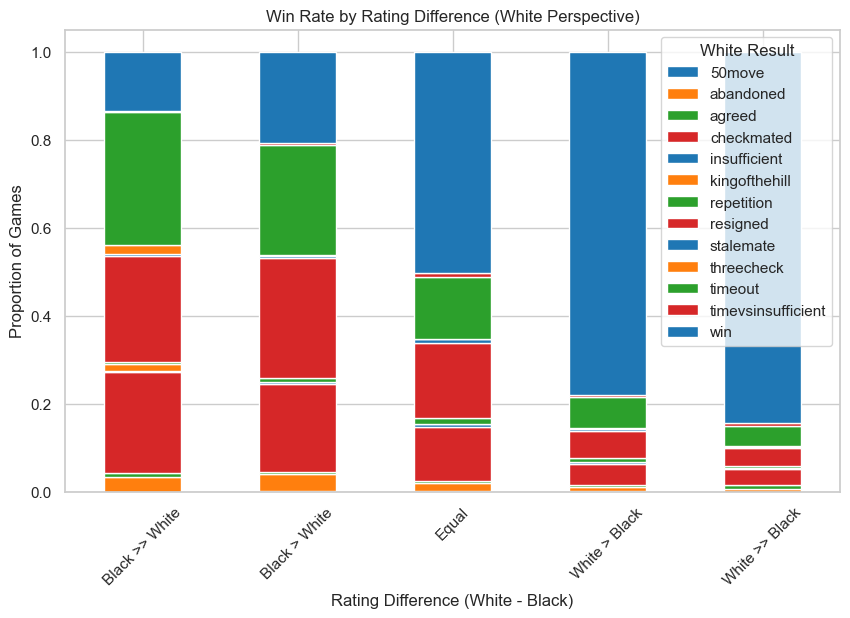


3. Win Rate by Rating Difference:
 white_result       50move  abandoned    agreed  checkmated  insufficient  \
rating_diff_bin                                                            
Black >> White   0.000000   0.033237  0.008309    0.229466      0.003516   
Black > White    0.000093   0.039828  0.004955    0.200168      0.003833   
Equal            0.000102   0.019071  0.004150    0.124153      0.005933   
White > Black    0.000094   0.010149  0.004793    0.048398      0.003947   
White >> Black   0.000000   0.005423  0.009888    0.034769      0.002871   

white_result     kingofthehill  repetition  resigned  stalemate  threecheck  \
rating_diff_bin                                                               
Black >> White        0.015340    0.004155  0.241611   0.003516    0.021732   
Black > White         0.000935    0.008134  0.272345   0.005329    0.002618   
Equal                 0.000178    0.012935  0.171538   0.008122    0.000204   
White > Black         0.000376    0.

In [14]:
# 3. Win Rate by Rating Difference
win_rate = df.groupby('rating_diff_bin')['white_result'].value_counts(normalize=True).unstack().fillna(0)
plt.figure()
win_rate.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Win Rate by Rating Difference (White Perspective)')
plt.xlabel('Rating Difference (White - Black)')
plt.ylabel('Proportion of Games')
plt.legend(title='White Result')
plt.xticks(rotation=45)
try:
    plt.savefig(os.path.join(output_dir, 'win_rate_by_rating_diff.png'))
    print(f"Saved plot: {os.path.join(output_dir, 'win_rate_by_rating_diff.png')}")
except Exception as e:
    print(f"Error saving win_rate_by_rating_diff.png: {e}")
plt.show()
plt.close()
print("\n3. Win Rate by Rating Difference:\n", win_rate)

Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\time_class_distribution.png


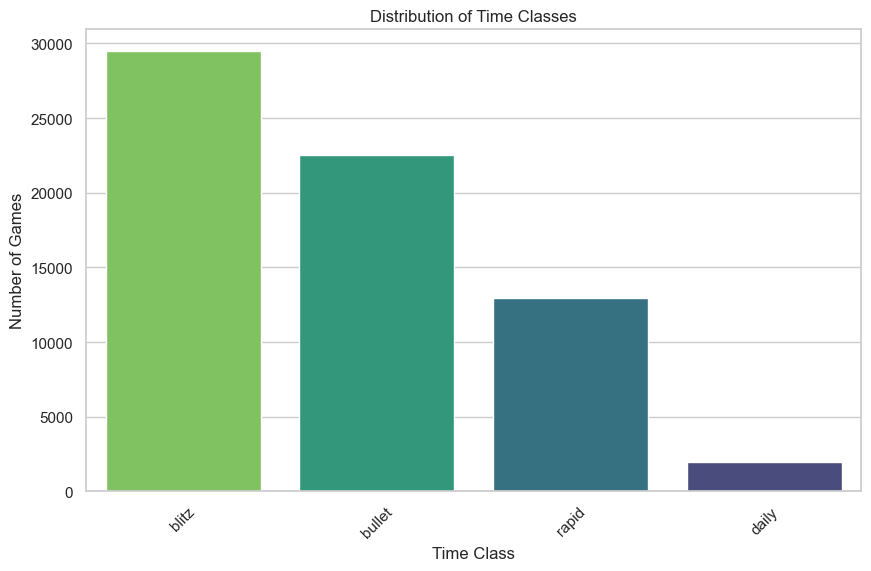


4. Time Class Counts:
 time_class
blitz     29468
bullet    22501
rapid     12933
daily      1973
Name: count, dtype: int64


In [15]:
# 4. Time Class Distribution
plt.figure()
sns.countplot(data=df, x='time_class', hue='time_class', 
              order=df['time_class'].value_counts().index, 
              palette='viridis', legend=False)
plt.title('Distribution of Time Classes')
plt.xlabel('Time Class')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
try:
    plt.savefig(os.path.join(output_dir, 'time_class_distribution.png'))
    print(f"Saved plot: {os.path.join(output_dir, 'time_class_distribution.png')}")
except Exception as e:
    print(f"Error saving time_class_distribution.png: {e}")
plt.show()
plt.close()
print("\n4. Time Class Counts:\n", df['time_class'].value_counts())

Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\time_vs_rating_diff.png


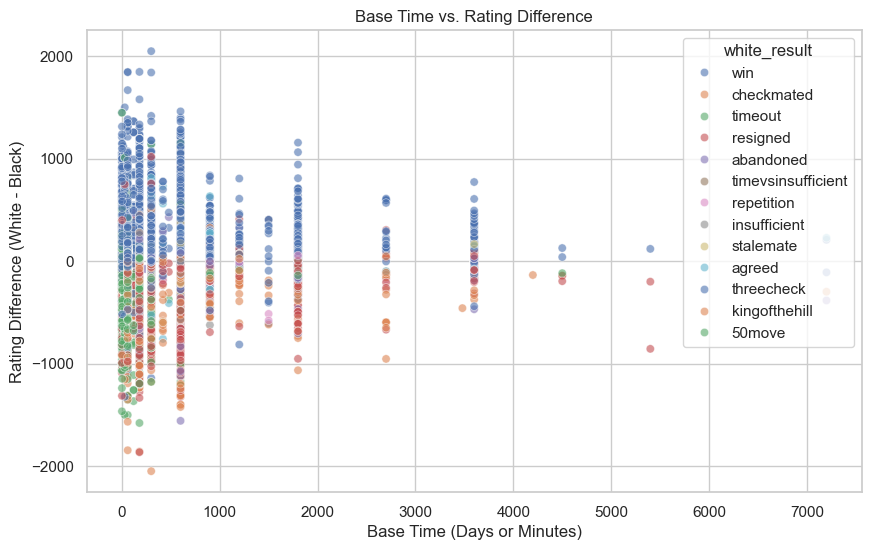


5. Correlation between Base Time and Rating Difference:
              base_time  rating_diff
base_time     1.000000    -0.000838
rating_diff  -0.000838     1.000000


In [16]:
# 5. Base Time vs. Rating Difference
plt.figure()
sns.scatterplot(data=df, x='base_time', y='rating_diff', hue='white_result', 
                palette='deep', alpha=0.6)
plt.title('Base Time vs. Rating Difference')
plt.xlabel('Base Time (Days or Minutes)')
plt.ylabel('Rating Difference (White - Black)')
try:
    plt.savefig(os.path.join(output_dir, 'time_vs_rating_diff.png'))
    print(f"Saved plot: {os.path.join(output_dir, 'time_vs_rating_diff.png')}")
except Exception as e:
    print(f"Error saving time_vs_rating_diff.png: {e}")
plt.show()
plt.close()
print("\n5. Correlation between Base Time and Rating Difference:\n", 
      df[['base_time', 'rating_diff']].corr())

Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\rated_distribution.png


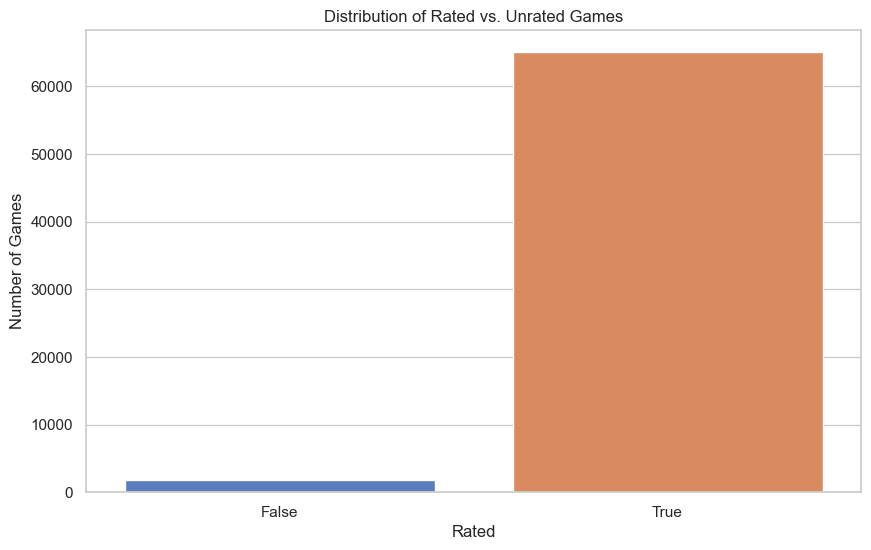


6. Rated vs. Unrated Counts:
 rated
True     65052
False     1823
Name: count, dtype: int64


In [17]:
# 6. Rated vs. Unrated Games
plt.figure()
sns.countplot(data=df, x='rated', hue='rated', palette='muted', legend=False)
plt.title('Distribution of Rated vs. Unrated Games')
plt.xlabel('Rated')
plt.ylabel('Number of Games')
try:
    plt.savefig(os.path.join(output_dir, 'rated_distribution.png'))
    print(f"Saved plot: {os.path.join(output_dir, 'rated_distribution.png')}")
except Exception as e:
    print(f"Error saving rated_distribution.png: {e}")
plt.show()
plt.close()
print("\n6. Rated vs. Unrated Counts:\n", df['rated'].value_counts())

Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\correlation_matrix.png


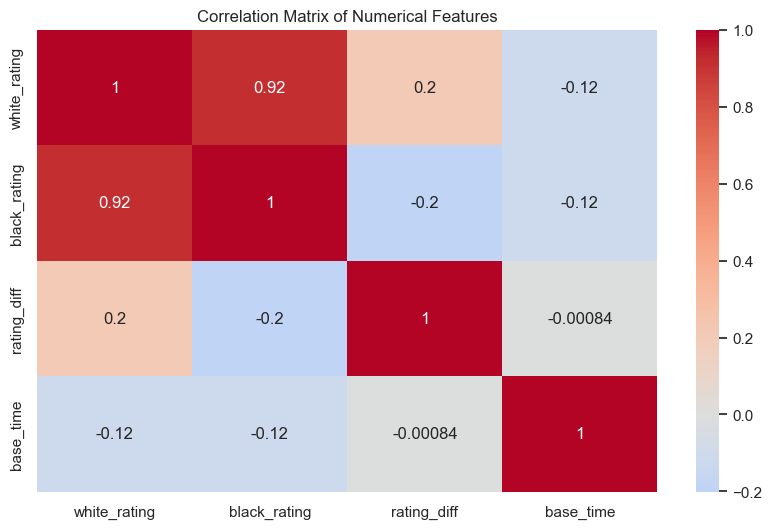


7. Correlation Matrix:
               white_rating  black_rating  rating_diff  base_time
white_rating      1.000000      0.917930     0.204611  -0.115346
black_rating      0.917930      1.000000    -0.200530  -0.115106
rating_diff       0.204611     -0.200530     1.000000  -0.000838
base_time        -0.115346     -0.115106    -0.000838   1.000000


In [18]:
# 7. Numerical Correlations
numerical_cols = ['white_rating', 'black_rating', 'rating_diff', 'base_time']
corr_matrix = df[numerical_cols].corr()
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
try:
    plt.savefig(os.path.join(output_dir, 'correlation_matrix.png'))
    print(f"Saved plot: {os.path.join(output_dir, 'correlation_matrix.png')}")
except Exception as e:
    print(f"Error saving correlation_matrix.png: {e}")
plt.show()
plt.close()
print("\n7. Correlation Matrix:\n", corr_matrix)


Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\move_count_distribution.png


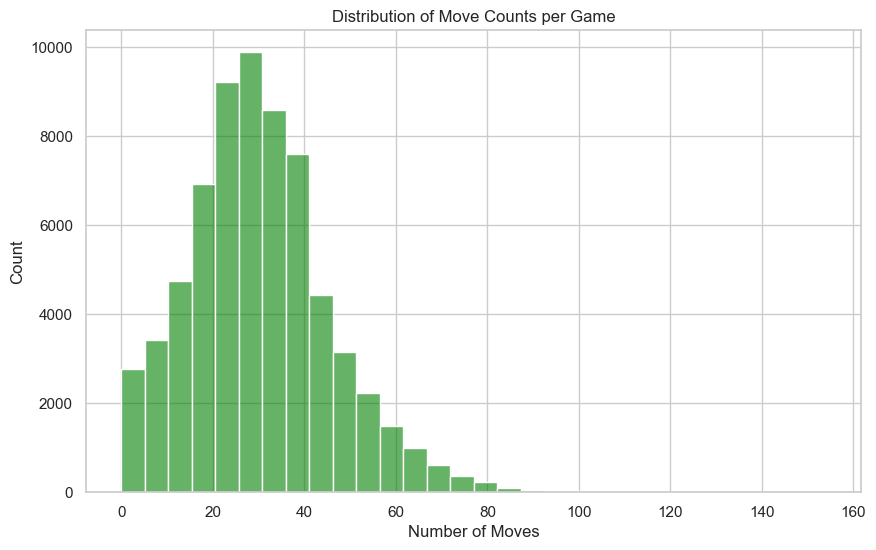

C:\Users\MICKS FOODS\AppData\Local\Temp\ipykernel_1988\2893990658.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='white_result', y='move_count', palette='muted')


Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\move_count_by_result.png


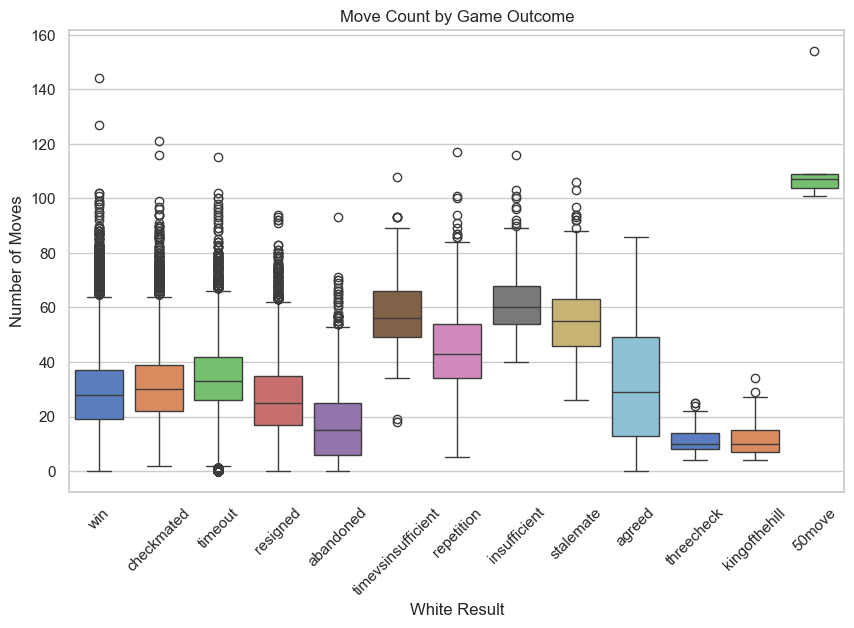


8. Move Count Statistics:
 count    66875.000000
mean        30.081705
std         15.421747
min          0.000000
25%         20.000000
50%         29.000000
75%         39.000000
max        154.000000
Name: move_count, dtype: float64


In [19]:
# 8. Move Count Analysis
if 'move_count' in df.columns and df['move_count'].notna().any():
    plt.figure()
    sns.histplot(data=df, x='move_count', bins=30, color='green', alpha=0.6)
    plt.title('Distribution of Move Counts per Game')
    plt.xlabel('Number of Moves')
    plt.ylabel('Count')
    try:
        plt.savefig(os.path.join(output_dir, 'move_count_distribution.png'))
        print(f"Saved plot: {os.path.join(output_dir, 'move_count_distribution.png')}")
    except Exception as e:
        print(f"Error saving move_count_distribution.png: {e}")
    plt.show()
    plt.close()

    plt.figure()
    sns.boxplot(data=df, x='white_result', y='move_count', palette='muted')
    plt.title('Move Count by Game Outcome')
    plt.xlabel('White Result')
    plt.ylabel('Number of Moves')
    plt.xticks(rotation=45)
    try:
        plt.savefig(os.path.join(output_dir, 'move_count_by_result.png'))
        print(f"Saved plot: {os.path.join(output_dir, 'move_count_by_result.png')}")
    except Exception as e:
        print(f"Error saving move_count_by_result.png: {e}")
    plt.show()
    plt.close()
    print("\n8. Move Count Statistics:\n", df['move_count'].describe())
else:
    print("\nWarning: 'move_count' is missing or empty. Skipping move count analysis.")

C:\Users\MICKS FOODS\AppData\Local\Temp\ipykernel_1988\1181270298.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=player_games.values, y=player_games.index, palette='viridis')


Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\top_players.png


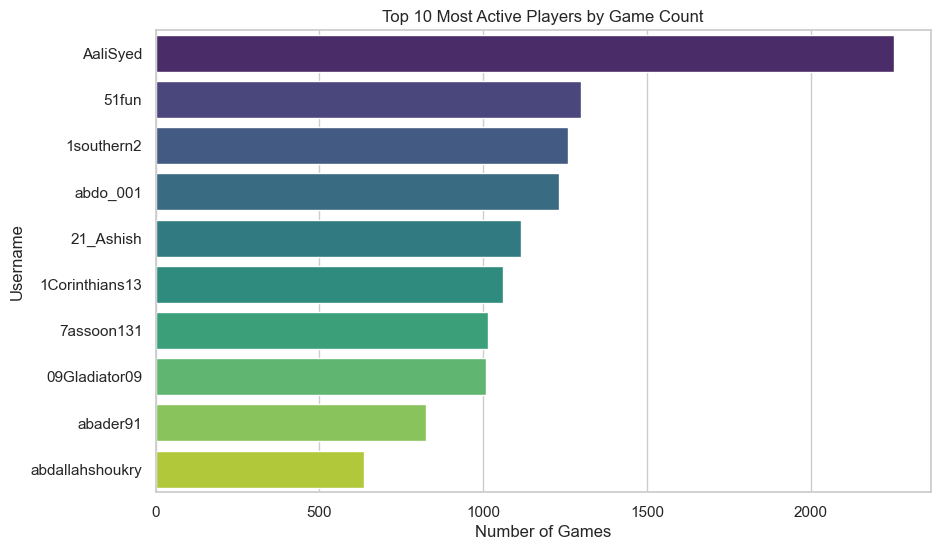


9. Top 10 Players by Game Count:
 AaliSyed           2253
51fun              1298
1southern2         1259
abdo_001           1231
21_Ashish          1117
1Corinthians13     1062
7assoon131         1016
09Gladiator09      1010
abader91            826
abdallahshoukry     636
Name: games, dtype: int64


In [20]:
# 9. Player Activity
player_games = pd.concat([
    df['white_username'].value_counts().rename('games'),
    df['black_username'].value_counts().rename('games')
]).groupby(level=0).sum().sort_values(ascending=False).head(10)
plt.figure()
sns.barplot(x=player_games.values, y=player_games.index, palette='viridis')
plt.title('Top 10 Most Active Players by Game Count')
plt.xlabel('Number of Games')
plt.ylabel('Username')
try:
    plt.savefig(os.path.join(output_dir, 'top_players.png'))
    print(f"Saved plot: {os.path.join(output_dir, 'top_players.png')}")
except Exception as e:
    print(f"Error saving top_players.png: {e}")
plt.show()
plt.close()
print("\n9. Top 10 Players by Game Count:\n", player_games)

C:\Users\MICKS FOODS\AppData\Local\Temp\ipykernel_1988\2035464085.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_openings.values, y=top_openings.index, palette='muted')


Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\top_opening_moves.png


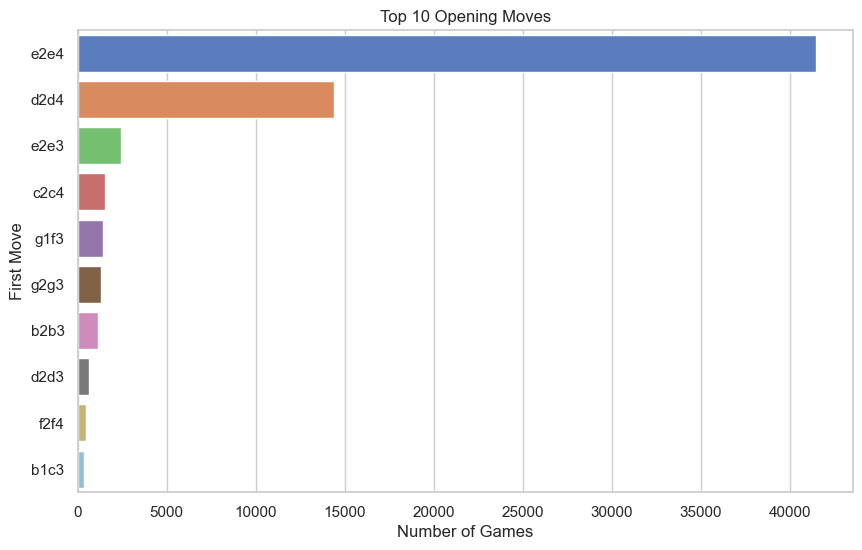


10. Top 10 Opening Moves:
 first_move
e2e4    41449
d2d4    14399
e2e3     2421
c2c4     1549
g1f3     1415
g2g3     1309
b2b3     1162
d2d3      609
f2f4      490
b1c3      348
Name: count, dtype: int64


In [21]:
# 10. Opening Move Analysis
if 'first_move' in df.columns and df['first_move'].notna().any():
    top_openings = df['first_move'].value_counts().head(10)
    plt.figure()
    sns.barplot(x=top_openings.values, y=top_openings.index, palette='muted')
    plt.title('Top 10 Opening Moves')
    plt.xlabel('Number of Games')
    plt.ylabel('First Move')
    try:
        plt.savefig(os.path.join(output_dir, 'top_opening_moves.png'))
        print(f"Saved plot: {os.path.join(output_dir, 'top_opening_moves.png')}")
    except Exception as e:
        print(f"Error saving top_opening_moves.png: {e}")
    plt.show()
    plt.close()
    print("\n10. Top 10 Opening Moves:\n", top_openings)
else:
    print("\nWarning: 'first_move' is missing or empty. Skipping opening move analysis.")

Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\piece_count_distribution.png


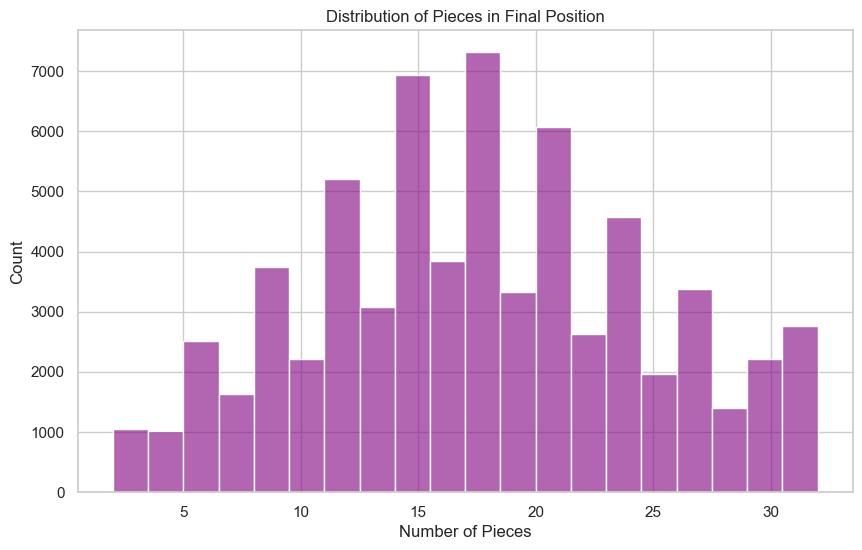


11. Piece Count Statistics:
 count    66875.000000
mean        17.346841
std          7.125808
min          2.000000
25%         12.000000
50%         17.000000
75%         22.000000
max         32.000000
Name: piece_count, dtype: float64


In [22]:
# 11. Final Board Position Complexity
if 'piece_count' in df.columns and df['piece_count'].notna().any():
    plt.figure()
    sns.histplot(data=df, x='piece_count', bins=20, color='purple', alpha=0.6)
    plt.title('Distribution of Pieces in Final Position')
    plt.xlabel('Number of Pieces')
    plt.ylabel('Count')
    try:
        plt.savefig(os.path.join(output_dir, 'piece_count_distribution.png'))
        print(f"Saved plot: {os.path.join(output_dir, 'piece_count_distribution.png')}")
    except Exception as e:
        print(f"Error saving piece_count_distribution.png: {e}")
    plt.show()
    plt.close()
    print("\n11. Piece Count Statistics:\n", df['piece_count'].describe())
else:
    print("\nWarning: 'piece_count' is missing or empty. Skipping piece count analysis.")

Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\outcome_symmetry.png


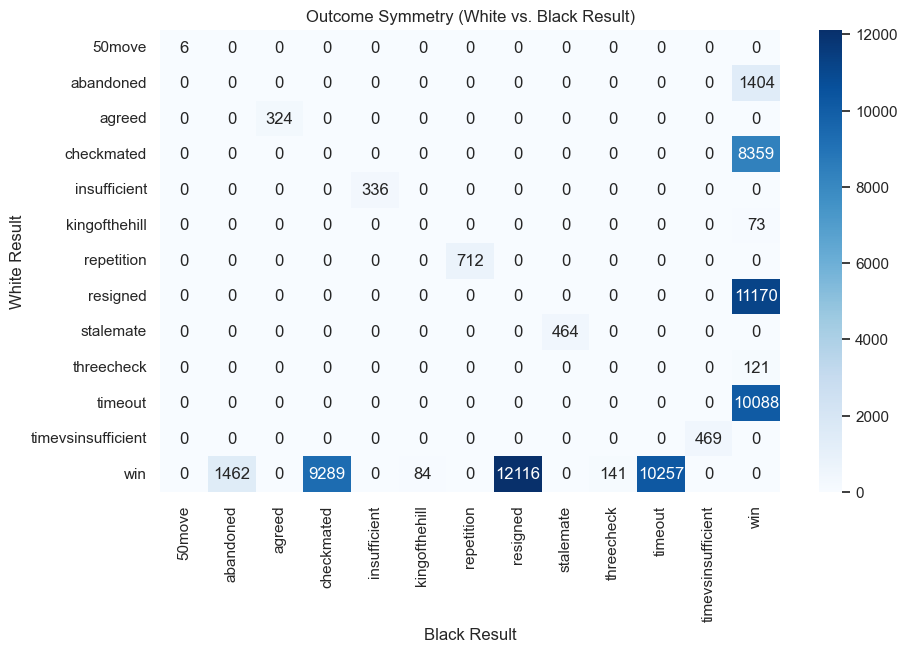


12. Outcome Symmetry (White vs. Black Result):
 black_result        50move  abandoned  agreed  checkmated  insufficient  \
white_result                                                              
50move                   6          0       0           0             0   
abandoned                0          0       0           0             0   
agreed                   0          0     324           0             0   
checkmated               0          0       0           0             0   
insufficient             0          0       0           0           336   
kingofthehill            0          0       0           0             0   
repetition               0          0       0           0             0   
resigned                 0          0       0           0             0   
stalemate                0          0       0           0             0   
threecheck               0          0       0           0             0   
timeout                  0          0       0      

In [23]:
# 12. Outcome Symmetry
outcome_cross = pd.crosstab(df['white_result'], df['black_result'])
plt.figure()
sns.heatmap(outcome_cross, annot=True, fmt='d', cmap='Blues')
plt.title('Outcome Symmetry (White vs. Black Result)')
plt.xlabel('Black Result')
plt.ylabel('White Result')
try:
    plt.savefig(os.path.join(output_dir, 'outcome_symmetry.png'))
    print(f"Saved plot: {os.path.join(output_dir, 'outcome_symmetry.png')}")
except Exception as e:
    print(f"Error saving outcome_symmetry.png: {e}")
plt.show()
plt.close()
print("\n12. Outcome Symmetry (White vs. Black Result):\n", outcome_cross)

Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\expected_score_vs_rating_diff.png


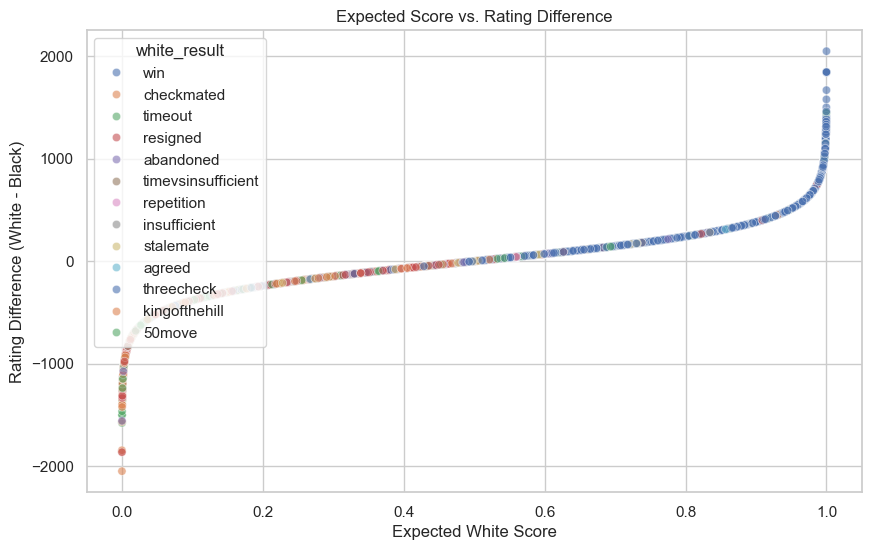


13. Expected Score Statistics:
 count    66875.000000
mean         0.500671
std          0.146290
min          0.000008
25%          0.444109
50%          0.500000
75%          0.557312
max          0.999992
Name: expected_white_score, dtype: float64


In [24]:
# 13. Rating Change Impact
def expected_score(rating_a, rating_b):
    return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

df['expected_white_score'] = df.apply(
    lambda x: expected_score(x['white_rating'], x['black_rating']), axis=1
)
plt.figure()
sns.scatterplot(data=df, x='expected_white_score', y='rating_diff', 
                hue='white_result', palette='deep', alpha=0.6)
plt.title('Expected Score vs. Rating Difference')
plt.xlabel('Expected White Score')
plt.ylabel('Rating Difference (White - Black)')
try:
    plt.savefig(os.path.join(output_dir, 'expected_score_vs_rating_diff.png'))
    print(f"Saved plot: {os.path.join(output_dir, 'expected_score_vs_rating_diff.png')}")
except Exception as e:
    print(f"Error saving expected_score_vs_rating_diff.png: {e}")
plt.show()
plt.close()
print("\n13. Expected Score Statistics:\n", df['expected_white_score'].describe())

Saved plot: D:\SHARDUL\STUDY\CHESS.COM EDA\rules_distribution.png


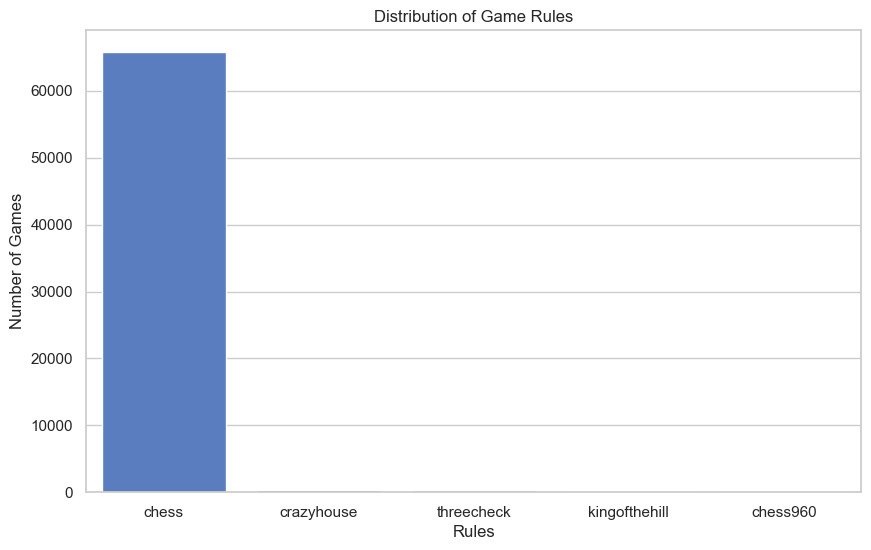


14. Game Rules Counts:
 rules
chess            65774
crazyhouse         389
threecheck         321
kingofthehill      242
chess960           149
Name: count, dtype: int64


In [25]:
# 14. Game Rules Distribution
plt.figure()
sns.countplot(data=df, x='rules', hue='rules', 
              order=df['rules'].value_counts().index, 
              palette='muted', legend=False)
plt.title('Distribution of Game Rules')
plt.xlabel('Rules')
plt.ylabel('Number of Games')
try:
    plt.savefig(os.path.join(output_dir, 'rules_distribution.png'))
    print(f"Saved plot: {os.path.join(output_dir, 'rules_distribution.png')}")
except Exception as e:
    print(f"Error saving rules_distribution.png: {e}")
plt.show()
plt.close()
print("\n14. Game Rules Counts:\n", df['rules'].value_counts())